In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import gc

TODO things to try:
- instead of taking 10%, split data by prop_country_id (idea from #3)
- bounding numerical variables, i.e normalising
- now i just drop all columns with missing data, but the following is better:
  - #2 does something with matching/mismatching historical data and the given hotel data
  - #2 sets missing values of competitors to 0
  - #1 imputes everything with negative value (??? don't know what he means. probably worst case scenario? or -1?)
- normalise price w.r.t search_id or prop_id or search_desintation id, as this can differ really greatly
- original distance i now put mean for 40K missing values, but we should look at whole search query and take max or mean or something.

First, we randomly get 10% of the data as it is so big. According to the #1 winner of the competition, this is still enough data to get a really good performance. Also, the #3 has this approach mentioned in their powerpoint.

In [2]:
doTest = False

if doTest == True:
    filepath = "data/test_set_VU_DM.csv"
else:
    filepath = "data/training_set_VU_DM.csv"

df = pd.read_csv(filepath, index_col=False)

In [3]:
search_ids = df.srch_id.unique()
print(f'There are {len(search_ids)} searches in the  set and {len(df)} data points')
df = df
#df = df[df.srch_id.isin(random.sample(list(search_ids), int(0.1 * len(search_ids))))]
print(f'There are {len(df.srch_id.unique())} searches in the smaller training set and {len(df)} data points')

There are 199795 searches in the  set and 4958347 data points
There are 199795 searches in the smaller training set and 4958347 data points


Remove information which is not present in test data

In [4]:
if doTest == False:
    df = df.drop(["position", "gross_bookings_usd"], axis=1)

Missing value imputation

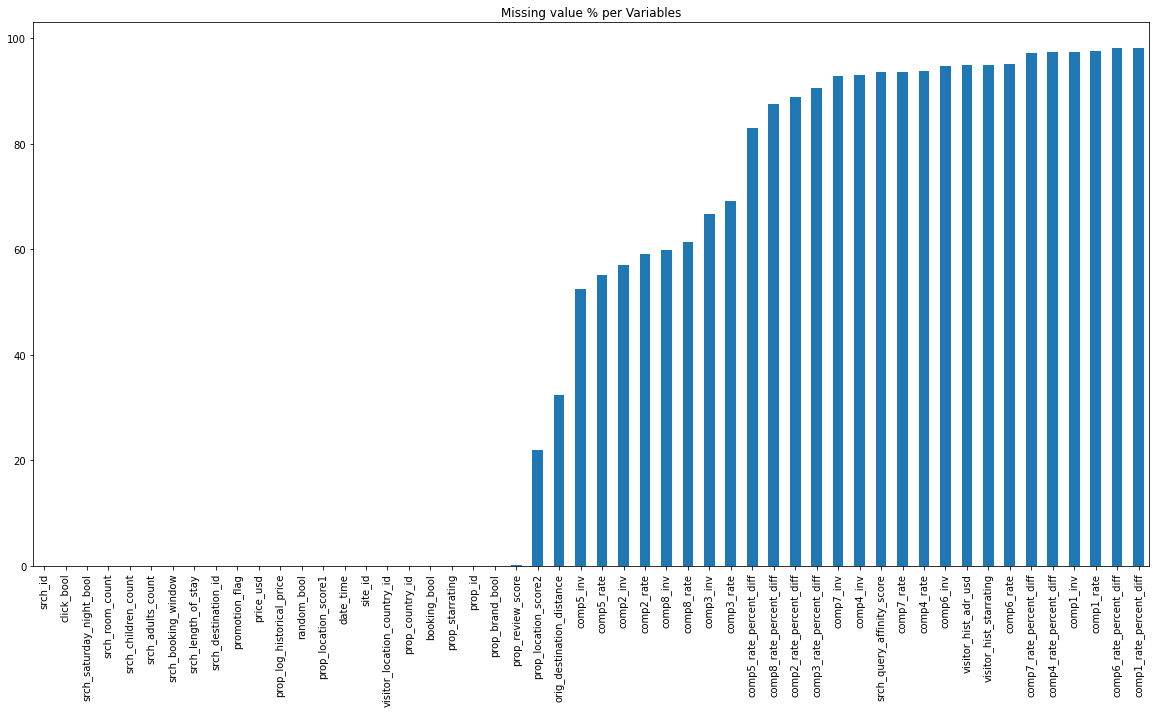

In [5]:
def plot_missing(data):
    missing = (data.isna().sum()/data.shape[0]*100) # missing percentages

    # plot missing 
    plt.figure(figsize=(20,10))
    missing.sort_values().plot(kind='bar')
    plt.title('Missing value % per Variables')
    
    return missing

missing = plot_missing(df)

In [6]:
def aggregate_competitor_info(df):
    df["agg_comp_rate"] = df.filter(regex=("comp.*rate$")).mean(axis=1)
    df["agg_comp_perc"] = df.filter(regex=("comp.*rate_perc")).mean(axis=1)
    df["agg_comp_inv"] = df.filter(regex=("comp.*inv")).mean(axis=1)
    return df.loc[:,~df.columns.str.startswith('comp')]
    print(df)
    
df = aggregate_competitor_info(df)

visitor_hist_starrating      94.920364
visitor_hist_adr_usd         94.897735
srch_query_affinity_score    93.598552
dtype: float64


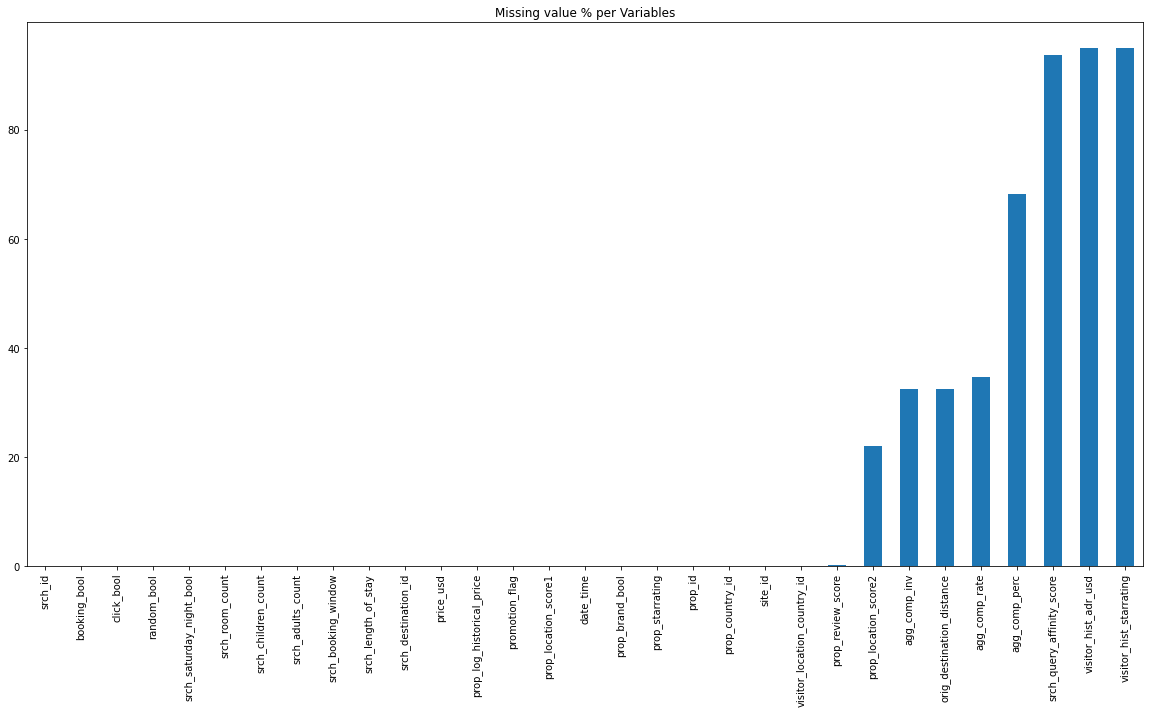

In [7]:
missing = plot_missing(df)

discard = missing[missing>90]
print(discard)
df.drop(discard.index, axis=1, inplace=True)

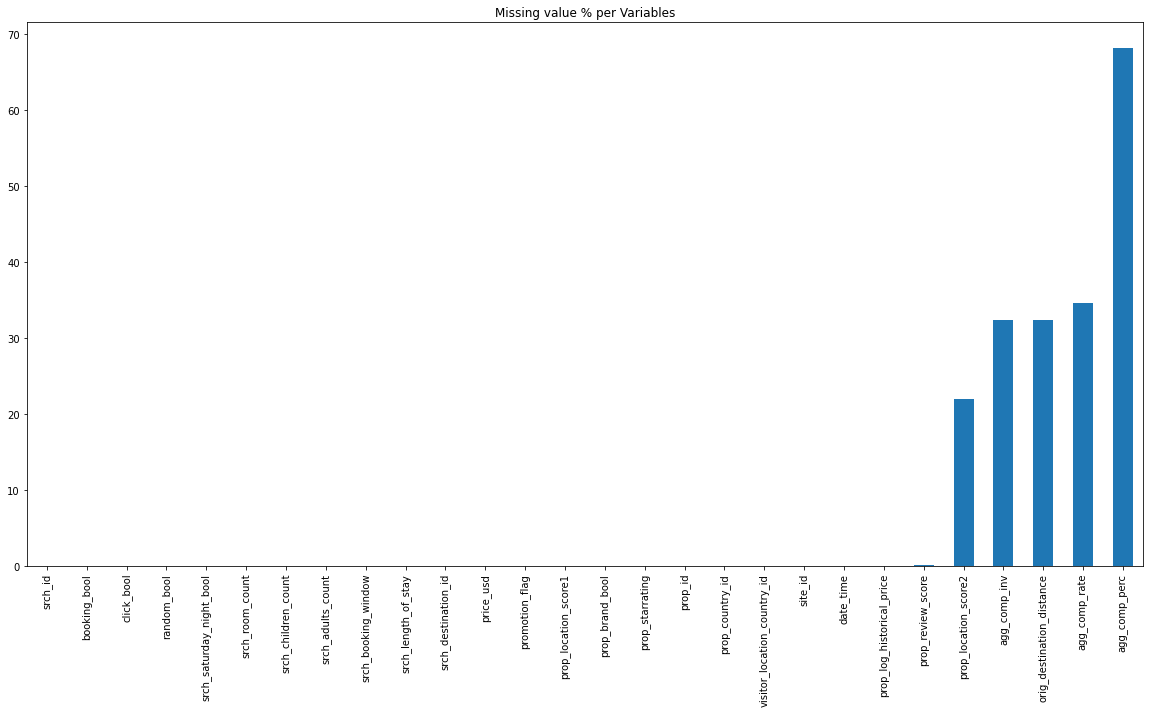

In [8]:
missing = plot_missing(df)

In [9]:
df[['srch_id','agg_comp_rate']].fillna(df[['srch_id','agg_comp_rate']].groupby('srch_id').transform('mean').squeeze())

,srch_id,agg_comp_rate
0,1,0.00
1,1,0.00
2,1,0.00
3,1,-0.75
4,1,0.00
...,...,...
4958342,332785,NaN
4958343,332785,NaN
4958344,332785,NaN
4958345,332785,NaN


In [10]:
def impute(impute):

    # hotel properties: impute with worst case scenario. Stolen from #2 and #3
    impute[['prop_review_score', 'prop_location_score2']] = impute[['prop_review_score','prop_location_score2']].fillna(0)

    # set missing original distances to max() for each searchquery and -1 if no info
    impute[['srch_id','orig_destination_distance']].fillna(impute[['srch_id','orig_destination_distance']].groupby('srch_id').transform('max').squeeze(), inplace=True)
    impute.orig_destination_distance.fillna(-1, inplace=True) 
    
    # competitor info: aggregate with mean w.r.t searchquery and otherwise 0
    impute[['srch_id','agg_comp_rate']].fillna(impute[['srch_id','agg_comp_rate']].groupby('srch_id').transform('mean').squeeze(), inplace=True)
    impute[['srch_id','agg_comp_perc']].fillna(impute[['srch_id','agg_comp_perc']].groupby('srch_id').transform('mean').squeeze(), inplace=True)
    impute[['srch_id','agg_comp_inv']].fillna(impute[['srch_id','agg_comp_inv']].groupby('srch_id').transform('mean').squeeze(), inplace=True)
    impute[['agg_comp_rate','agg_comp_perc', 'agg_comp_inv']] = impute[['agg_comp_rate','agg_comp_perc', 'agg_comp_inv']].fillna(0) 

impute(df)

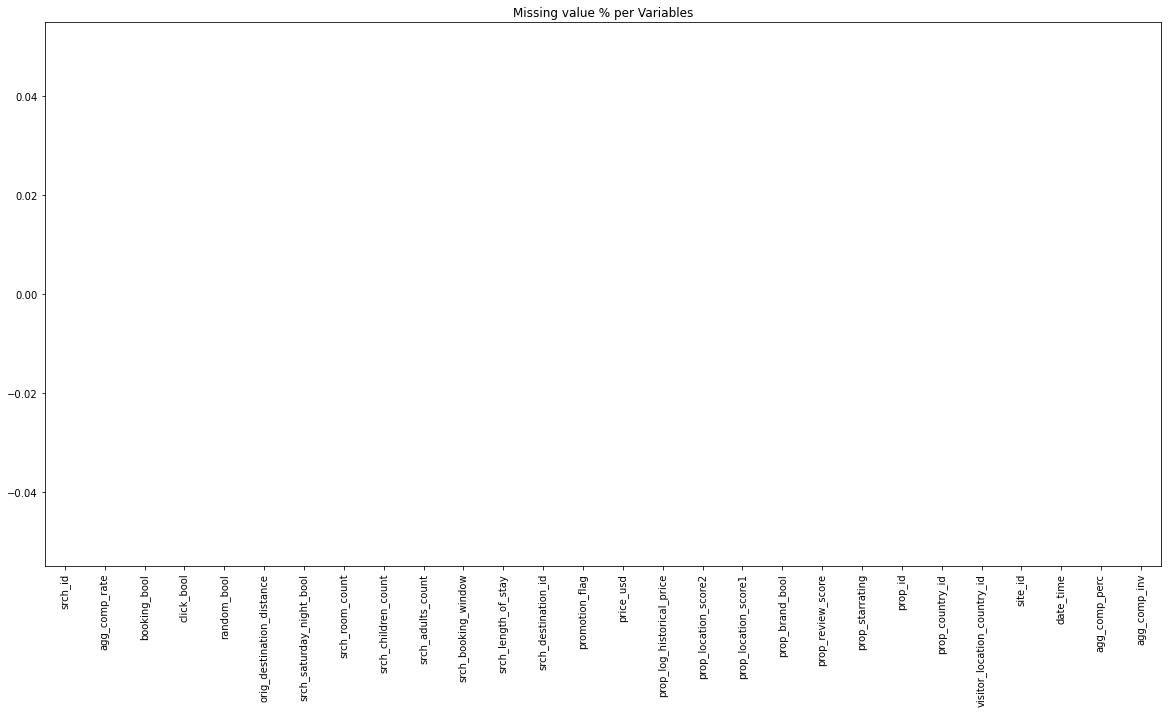

In [11]:
missing = plot_missing(df)

In [12]:
df.describe()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,...,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,click_bool,booking_bool,agg_comp_rate,agg_comp_perc,agg_comp_inv
count,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,...,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06,4.958347e+06
mean,1.663666e+05,9.953133e+00,1.753405e+02,1.739739e+02,7.007918e+04,3.180525e+00,3.772166e+00,6.346994e-01,2.872589e+00,1.017133e-01,...,3.504918e-01,1.110525e+00,5.022127e-01,8.789749e+02,2.959004e-01,4.474858e-02,2.791051e-02,1.282210e-02,1.283690e+01,2.892821e-02
std,9.611223e+04,7.646890e+00,6.591625e+01,6.834525e+01,4.060992e+04,1.051024e+00,1.059583e+00,4.815144e-01,1.531011e+00,1.508413e-01,...,7.325692e-01,4.172290e-01,4.999952e-01,1.771913e+03,4.564465e-01,2.067514e-01,1.647165e-01,3.497910e-01,8.642864e+02,1.843058e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00
25%,8.293600e+04,5.000000e+00,1.000000e+02,1.000000e+02,3.501000e+04,3.000000e+00,3.500000e+00,0.000000e+00,1.790000e+00,1.400000e-03,...,0.000000e+00,1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.665070e+05,5.000000e+00,2.190000e+02,2.190000e+02,6.963800e+04,3.000000e+00,4.000000e+00,1.000000e+00,2.770000e+00,3.550000e-02,...,0.000000e+00,1.000000e+00,1.000000e+00,1.466200e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.497240e+05,1.400000e+01,2.190000e+02,2.190000e+02,1.051680e+05,4.000000e+00,4.500000e+00,1.000000e+00,4.040000e+00,1.373000e-01,...,0.000000e+00,1.000000e+00,1.000000e+00,8.004300e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00
max,3.327850e+05,3.400000e+01,2.310000e+02,2.300000e+02,1.408210e+05,5.000000e+00,5.000000e+00,1.000000e+00,6.980000e+00,1.000000e+00,...,9.000000e+00,8.000000e+00,1.000000e+00,1.166664e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.001584e+06,1.000000e+00


Create new target, i.e relevance

In [13]:
if doTest == False:
    df['target'] = np.where(df.click_bool == 1, 1,0)
    df['target'] = np.where(df.booking_bool == 1, 5, df.target)
    
    df.loc[:,['target', 'click_bool', 'booking_bool']].head(n=20)

In [14]:
if doTest == False:
    df.to_csv("data/dummy/train.csv", index=False)
else:
    df.to_csv("data/dummy/test.csv", index=False)

In [15]:
del df
gc.collect()

27629